In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")


In [ ]:
set_seed()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
folder_path = "./drive/MyDrive/ColabData/"

Random seed set as 42


In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
image_datasets = {x: torchvision.datasets.CIFAR10(
    root=folder_path + "TrainingData",
    train=x == 'train',
    download=True,
    transform=transform
) for x in ['train', 'test']}

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_set_size = int(len(image_datasets['train']) * 0.8)
valid_set_size = len(image_datasets['train']) - train_set_size

image_datasets['train'], image_datasets['val'] = torch.utils.data.random_split(image_datasets['train'], [train_set_size, valid_set_size])

In [ ]:
def create_dataloaders(batch_size=64):
    return {x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=batch_size, 
    ) for x in ['train', 'val', 'test']}

In [ ]:
dataloaders = create_dataloaders()

In [ ]:
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}
dataset_sizes

{'train': 40000, 'val': 10000, 'test': 10000}

In [ ]:
class_names = dataloaders['test'].dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

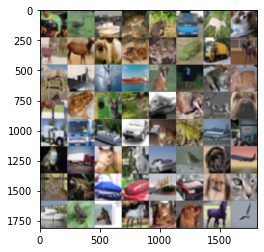

In [ ]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)


inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    y_loss = {'train': [], 'val': []}
    y_acc = {'train': [], 'val': []}

    best_acc = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                y_loss[phase].append(epoch_loss)
                y_acc[phase].append(epoch_acc.cpu().numpy())

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                  
    model.load_state_dict(best_model_wts)
    return model, (y_loss, y_acc)

In [ ]:
def visualize_acc_preds(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    correct = 0
    total = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            print(f'Accuracy of the network on the 10000 test images: {int(100 * correct / total)} %\n')

            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

In [ ]:
model_1 = AlexNet(len(dataloaders['test'].dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)

In [ ]:
model_1, (y_loss, y_acc) = train_model(model_1, criterion, optimizer)

Epoch 1/10
----------
train Loss: 1.5643 Acc: 0.4195
val Loss: 1.4200 Acc: 0.5022
Epoch 2/10
----------
train Loss: 1.1503 Acc: 0.5866
val Loss: 1.0514 Acc: 0.6281
Epoch 3/10
----------
train Loss: 0.9515 Acc: 0.6627
val Loss: 0.9189 Acc: 0.6768
Epoch 4/10
----------
train Loss: 0.8287 Acc: 0.7052
val Loss: 0.8441 Acc: 0.7058
Epoch 5/10
----------
train Loss: 0.7401 Acc: 0.7375
val Loss: 0.8150 Acc: 0.7215
Epoch 6/10
----------
train Loss: 0.6691 Acc: 0.7658
val Loss: 0.7612 Acc: 0.7414
Epoch 7/10
----------
train Loss: 0.6159 Acc: 0.7825
val Loss: 0.7056 Acc: 0.7572
Epoch 8/10
----------
train Loss: 0.5583 Acc: 0.8036
val Loss: 0.6966 Acc: 0.7640
Epoch 9/10
----------
train Loss: 0.5146 Acc: 0.8166
val Loss: 0.6428 Acc: 0.7782
Epoch 10/10
----------
train Loss: 0.4707 Acc: 0.8348
val Loss: 0.6954 Acc: 0.7689


Accuracy of the network on the 10000 test images: 84 %



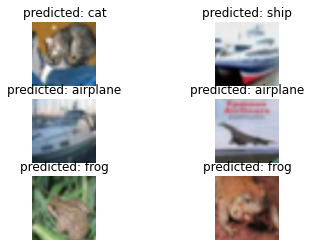

In [ ]:
visualize_acc_preds(model_1)

In [ ]:
dataloaders = create_dataloaders(batch_size=128)

In [ ]:
model_2 = AlexNet(len(dataloaders['test'].dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)
model_2, (y_loss, y_acc) = train_model(model_2, criterion, optimizer)

Epoch 1/10
----------
train Loss: 1.6876 Acc: 0.3714
val Loss: 1.4655 Acc: 0.4744
Epoch 2/10
----------
train Loss: 1.2550 Acc: 0.5448
val Loss: 1.1439 Acc: 0.5932
Epoch 3/10
----------
train Loss: 1.0466 Acc: 0.6218
val Loss: 1.0088 Acc: 0.6429
Epoch 4/10
----------
train Loss: 0.9195 Acc: 0.6747
val Loss: 0.8785 Acc: 0.6921
Epoch 5/10
----------
train Loss: 0.8238 Acc: 0.7072
val Loss: 0.8470 Acc: 0.7073
Epoch 6/10
----------
train Loss: 0.7550 Acc: 0.7331
val Loss: 0.8516 Acc: 0.7077
Epoch 7/10
----------
train Loss: 0.6932 Acc: 0.7544
val Loss: 0.7837 Acc: 0.7294
Epoch 8/10
----------
train Loss: 0.6412 Acc: 0.7741
val Loss: 0.8296 Acc: 0.7199
Epoch 9/10
----------
train Loss: 0.5961 Acc: 0.7891
val Loss: 0.7500 Acc: 0.7462
Epoch 10/10
----------
train Loss: 0.5489 Acc: 0.8083
val Loss: 0.7324 Acc: 0.7533


Accuracy of the network on the 10000 test images: 78 %



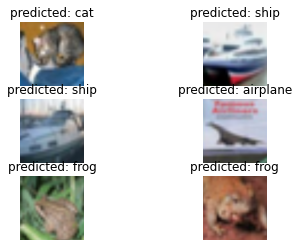

In [ ]:
visualize_acc_preds(model_2)

In [ ]:
model_3 = AlexNet(len(dataloaders['test'].dataset.classes)).to(device)
optimizer = optim.SGD(model_3.parameters(), lr=0.1, momentum=0.9)
model_3, (y_loss, y_acc) = train_model(model_3, criterion, optimizer)

Epoch 1/10
----------
train Loss: 1.8614 Acc: 0.3109
val Loss: 1.6621 Acc: 0.3881
Epoch 2/10
----------
train Loss: 1.4977 Acc: 0.4496
val Loss: 1.3337 Acc: 0.5136
Epoch 3/10
----------
train Loss: 1.3071 Acc: 0.5286
val Loss: 1.1614 Acc: 0.5920
Epoch 4/10
----------
train Loss: 1.1378 Acc: 0.5957
val Loss: 1.1867 Acc: 0.5969
Epoch 5/10
----------
train Loss: 1.0045 Acc: 0.6470
val Loss: 0.9306 Acc: 0.6776
Epoch 6/10
----------
train Loss: 0.8767 Acc: 0.6957
val Loss: 0.8278 Acc: 0.7105
Epoch 7/10
----------
train Loss: 0.7887 Acc: 0.7253
val Loss: 0.8418 Acc: 0.7145
Epoch 8/10
----------
train Loss: 0.7139 Acc: 0.7529
val Loss: 0.7352 Acc: 0.7463
Epoch 9/10
----------
train Loss: 0.6632 Acc: 0.7701
val Loss: 0.7322 Acc: 0.7516
Epoch 10/10
----------
train Loss: 0.6084 Acc: 0.7886
val Loss: 0.6701 Acc: 0.7696


Accuracy of the network on the 10000 test images: 81 %



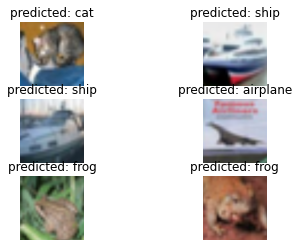

In [ ]:
visualize_acc_preds(model_3)